In [1]:
%load_ext autoreload
%autoreload 2
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import QTable, Table, vstack, join 
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
profile = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/analysis_mock_CLMM/mock_CLMM.pkl')

In [4]:
len(profile)

300

In [5]:
profile['halo_id'] = profile['cluster_id']

In [6]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = np.linspace(0.2, 0.4, 4)
Z_bin = binning(z_corner)

m_corner = np.logspace(14,14.5,6)
#m_corner = np.linspace(1e14, 1e15, 3)
Mass_bin = binning(m_corner)

In [7]:
profile_mock = prf.stacked_profile(profile = profile,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_mock = prf.bootstrap_covariance(profile = profile,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


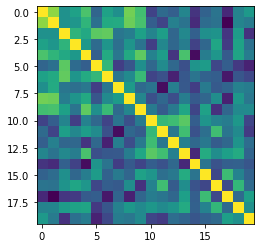

In [9]:
index = 1
plt.imshow(corr(covariance_mock['cov_t'][index], covariance_mock['cov_t'][index].diagonal() > 0)[0])

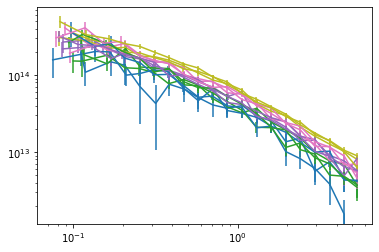

In [10]:
for i,p in enumerate(profile_mock):
    c = covariance_mock[i]
    #plt.plot(p['radius'], p['gx'])
    plt.errorbar(p['radius'], p['gt'], np.sqrt(c['cov_t'].diagonal()))
    plt.loglog([],[])

In [11]:
fit_mock = fit.fit_WL_cluster_mass(profile = profile_mock, covariance = covariance_mock, a = 0, b = .1, rmax = 6, two_halo_term = False, fix_c = False, is_covariance_diagonal = True)
fit_mock_full = fit.fit_WL_cluster_mass(profile = profile_mock, covariance = covariance_mock, a = 0, b = .1, rmax = 6, two_halo_term = False, fix_c = False, is_covariance_diagonal = False)

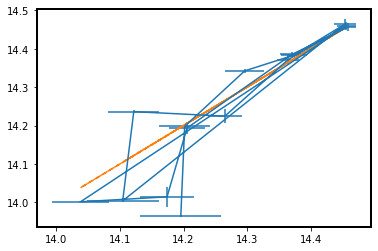

In [94]:
plt.errorbar(fit_mock['logm200_w'] ,fit_mock_full['logm200_w'], fit_mock_full['logm200_w_err'] ,fit_mock['logm200_w_err'])
plt.plot(fit_mock['logm200_w'],fit_mock['logm200_w'], '--')

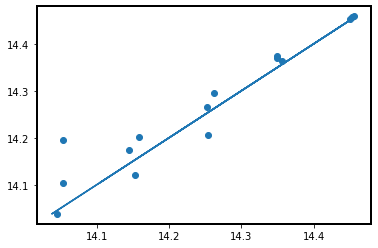

In [95]:
plt.scatter(np.log10(fit_mock['obs_mean']) ,fit_mock['logm200_w'])
plt.plot(fit_mock['logm200_w'],fit_mock['logm200_w'])

In [14]:
index = 1
data = Table(fit_mock)[index]
cov = covariance_mock[index]

In [75]:
data['logm200_w'], data['logm200_w_err']

(14.20171075669909, 0.040191455431980216)

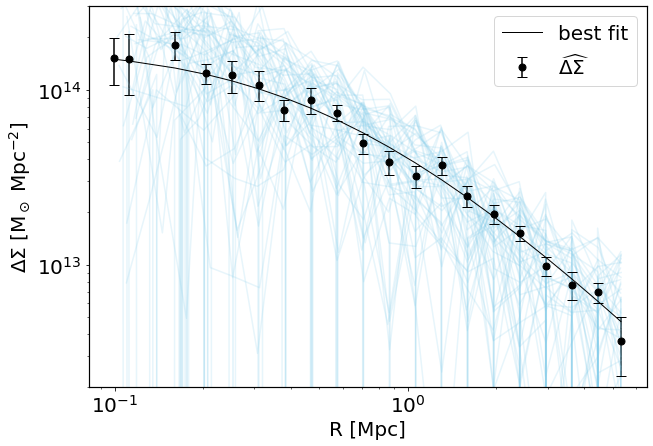

In [47]:
plt.figure(figsize=(10,7))
plt.rcParams['axes.linewidth']= 1.2
for p in profile:
    if (data['obs_bin'][0] < p['M200c'])*(data['obs_bin'][1] > p['M200c']):
        mask = p['radius_av'] > 0
        plt.loglog(p['radius_av'][mask], p['gt_av'][mask], 'skyblue', alpha = .2)
plt.errorbar(data['radius'], data['gt'], cov['cov_t'].diagonal()**.5, 
             capsize = 5, markersize = 7, fmt = ' ', c = 'k', marker = 'o', label = r'$\widehat{\Delta\Sigma}$')
plt.loglog(data['radius_model'], data['1h_term'], label = 'best fit', c='k', linewidth = 1)
plt.xlabel('R [Mpc]', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 20)
plt.ylim(2e12, 3e14)
plt.tick_params(axis='both', which = 'major', labelsize= 20)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/DS_mock_stack.png', bbox_inches='tight', dpi=300)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


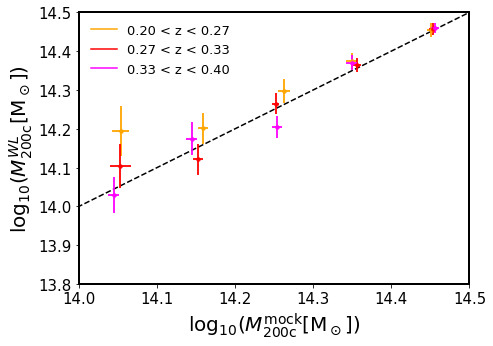

In [78]:
fit = [fit_mock]
fit_label = [r'$M200c$',r'$Mfof$']
import matplotlib.pyplot as plt
plt.figure(figsize = (7,5))
plt.rcParams['axes.linewidth']= 2
plt.tick_params(axis='both', which = 'major', labelsize= 15)
color_fit = ['k','r','b']
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
marker = ['s','o','^','.']
marker_fit = ['-',':','-','-']

for i, z_bin in enumerate(Z_bin):
    
    plt.plot([],[], '-', c = color_z[i],label = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}',)
    
    f = Table(fit_mock)

    mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])

    mask = mask

    f_cut = f[mask]

    a_t = 1./(1 + f_cut['z_mean'])

    logm = np.log10(f_cut['obs_mean']) 
    logm_err = f_cut['obs_rms']/(np.log(10)*(f_cut['obs_mean']))
    logm200w = f_cut['logm200_w']
    logm200w_err = f_cut['logm200_w_err']

    plt.errorbar(logm,logm200w,logm200w_err, logm_err,\
                marker = '.', fmt= ' ', color = color_z[i], capsize = 0,markersize=7,\
                elinewidth=2,linewidth=1.5, alpha = 0.9)

ylabel = r'$\log_{10}($' + r'$M_{\rm 200c}^{WL}$' + r'$[\rm{M}_\odot])$'
xlabel = r'$\log_{10}($' + r'$M_{\rm 200c}^{\rm mock}$' + r'$[\rm{M}_\odot])$'
#xlabel = r'$\log_{10}($' + r'$M_{\rm fof}^{\rm DC2}$' + r'$[\rm{M}_\odot])$'
m = np.linspace(13,15,10)
plt.plot(m,m,'--k',zorder = 1, alpha = 1)
plt.xlim(14,14.5)
plt.ylim(13.8,14.5)
plt.ticklabel_format(useOffset=False)
plt.xlabel(xlabel, fontsize = 20)
plt.ylabel(ylabel, fontsize = 20)
plt.legend(loc='upper left', frameon = False, fontsize = 13, numpoints = 1)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/M200cw_M200c_validation.png', bbox_inches='tight', dpi=300)

3 5
      z_mean       ...            radius_model [20]            
------------------ ... ----------------------------------------
0.2406601655804121 ... 0.11254476140362955 .. 5.337803367306045
       z_mean       ...            radius_model [20]            
------------------- ... ----------------------------------------
0.22760676933098775 ... 0.11253732327228921 .. 5.336758727145449
       z_mean       ...            radius_model [20]           
------------------- ... ---------------------------------------
0.23178079454468525 ... 0.1114901583603718 .. 5.333386921736378
      z_mean       ...            radius_model [20]           
------------------ ... ---------------------------------------
0.2349723130099227 ... 0.1132407060324872 .. 5.331519197817698
      z_mean       ...            radius_model [20]            
------------------ ... ----------------------------------------
0.2405193335773071 ... 0.11237942887993138 .. 5.334468621922171
      z_mean       ...            ra

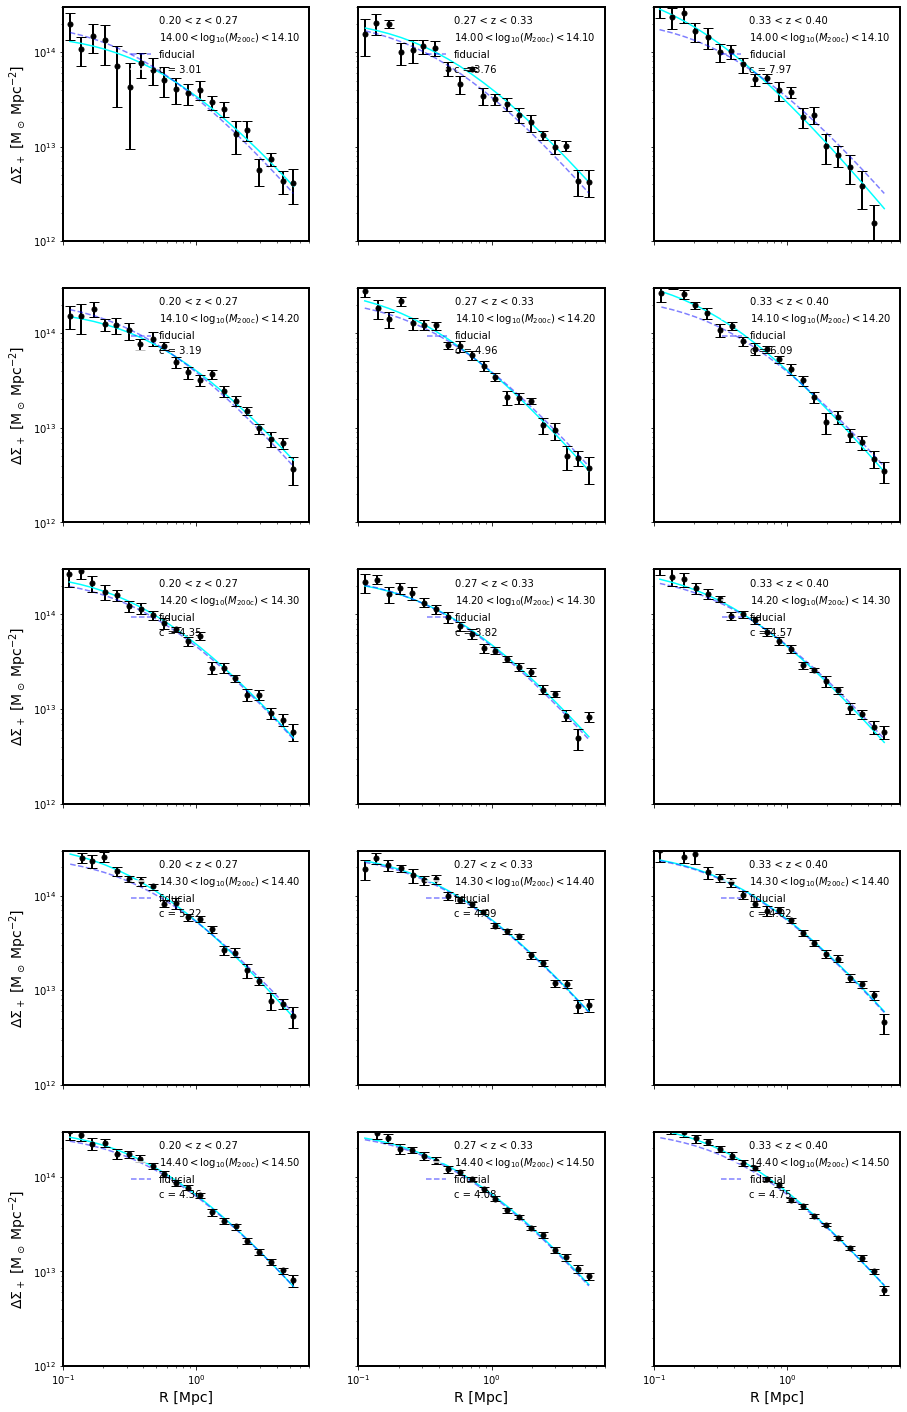

In [167]:
n_z_bin = len(Z_bin) - 0
n_m_bin = len(Mass_bin) - 0
print(n_z_bin, n_m_bin)
scale = 5
fig, axs = plt.subplots(n_m_bin,n_z_bin, figsize = (scale*n_z_bin,scale*n_m_bin))
for j, z_bin in enumerate(Z_bin):

    if j >= n_z_bin: continue
        
    for i, m_bin in enumerate(Mass_bin):

        if i >= n_m_bin: continue
            
        label_z = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
        label_M = f'{np.log10(m_bin[0]):.2f}' + r'$ < \log_{10}(M_{\rm 200c}) < $' + f'{np.log10(m_bin[1]):.2f}'
        axs[i, j].plot([], [], 'w', label = label_z)
        axs[i, j].plot([], [], 'w', label = label_M)
        c = ['r','b']
        fmt = ['-', '--']
        marker = ['o', 's']
        markersize = [2,2]
        name = ['center cosmoDC2', 'center RedMapper']
        profile_ = fit_mock
        covariance = [covariance_mock]
        mask_z = (profile_['z_mean'] > z_bin[0])*(profile_['z_mean'] < z_bin[1])
        mask_m = (profile_['obs_mean'] > m_bin[0])*(profile_['obs_mean'] < m_bin[1])
        index = np.arange(len(profile_))
        index_cut = index[mask_m * mask_z]
        f_cut = profile_[index_cut]
        print(f_cut)
        if len(f_cut) == 0: continue
        gt_err = np.array(covariance[0][index_cut]['gt_err'][0])
        axs[i, j].plot(f_cut['radius_model'][0], f_cut['1h_term'][0], '-', c = 'cyan')
        #axs[i, j].plot(f_cut['radius_model'][0], f_cut['2h_term'][0], '-', c = 'orange')
        #axs[i, j].plot(f_cut['radius_model'][0], f_cut['1h_term'][0] + f_cut['2h_term'][0],'--', c = 'k')
        cfiducial = 4
        fiducial = modele_ds(f_cut['radius_model'][0], np.log10(f_cut['obs_mean']), cfiducial, f_cut['z_mean'])
        axs[i, j].plot(f_cut['radius_model'][0], fiducial,'--', c = 'b', alpha = 0.5, label = 'fiducial')
        mask = f_cut['mask'][0]
        axs[i, j].errorbar(f_cut['radius_model'][0][mask], f_cut['gt'][0][mask],gt_err[mask], c = 'k'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 5, markerfacecolor = None)
        axs[i, j].errorbar(f_cut['radius_model'][0][np.invert(mask)], f_cut['gt'][0][np.invert(mask)],gt_err[np.invert(mask)],  c = 'cyan'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 5, markerfacecolor = None)
        c = f_cut['c_w'][0]
        label_n = f'c = {c:.2f}'
        axs[i, j].plot([], [], 'w', label = label_n)
        axs[i, j].set_ylim(1e12, 3e14)
        axs[i, j].set_xlim(0.1, 7)
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].legend(frameon = False, loc = 'upper right', fontsize = 10)
        axs[i, j].set_xlabel('R [Mpc]', fontsize = 14)
        axs[i, j].set_ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 14)

for ax in fig.get_axes():
    ax.label_outer()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/profile_attenuation.png', bbox_inches='tight', dpi=300)